# Food Image classification 

## Load Dataset

### Load Food_101 dataset from tensorflow_datasets

- Food101 dataset contains 101,000 images of foods
- total 101 classes with each class containing 1000 images
- training data and test data will have 75,750  and 25,250 images respectively

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
datasets=tfds.list_builders()

In [ ]:
print("food101" in datasets) ## make sure tfds dataset contains food101 data

True


In [ ]:
(train_data,test_data), info= tfds.load(name="food101",
                                        split=["train","validation"],
                                        shuffle_files=True,
                                        as_supervised=True,
                                        with_info=True)

In [ ]:
info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo n

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
info.description

"This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels."

In [ ]:
info.splits['train'].num_examples

75750

In [ ]:
class_names=info.features['label'].names

In [ ]:
for image, label in train_data.take(1):
    print(class_names[label])

cheesecake


(-0.5, 511.5, 511.5, -0.5)

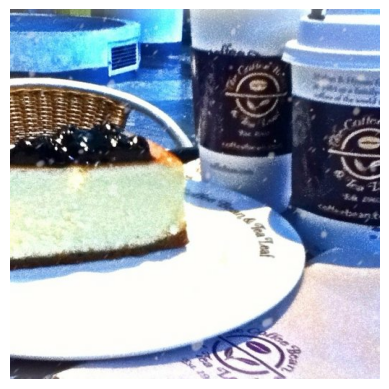

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(image)
plt.axis(False)

## Designing Data input pipeline

- preprocess image
    - resize
    - cast to float32
- shuffle data
- make batches 
- prefetch

In [ ]:
image.dtype

tf.uint8

In [1]:
import tensorflow as tf

In [ ]:
def preprocess_img(image,label,img_shape=224):
    img=tf.image.resize(image,[img_shape,img_shape])
    return  tf.cast(img, tf.float32 ), label

In [ ]:
preprocess_img(image,label)[1].shape

TensorShape([])

In [ ]:
train_data=train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


test_data=test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data=test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from helper_functions import create_tensorboard_callback 

## Feature Extaraction 

### Callbacks to track model

In [ ]:
checkpoint_path="food_vision_101_checkpoint/checkpoint.ckpt"

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

### Set Mixed precision policy

#### make sure GPU is compatible for mixed precision 

In [15]:
!nvidia-smi

Wed May  3 14:00:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8                2W /  N/A|   3537MiB /  4096MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [6]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [3]:
from tensorflow.keras import layers

input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(input_shape, name='input_layer')

x=base_model(inputs, training=False)

x=layers.GlobalAveragePooling2D(name='Global_avg_pooling_2D')(x)

x=layers.Dense(101)(x)

output = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model_1=tf.keras.Model(inputs,output)

model_1.compile(loss='sparse_categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_avg_pooling_2D (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for layer in model_1.layers:
    print(layer.name , layer.dtype_policy)

input_layer <Policy "float32">
efficientnetb0 <Policy "mixed_float16">
Global_avg_pooling_2D <Policy "mixed_float16">
dense <Policy "mixed_float16">
softmax_float32 <Policy "float32">


In [ ]:
tf.get_logger().setLevel('ERROR')

history_1=model_1.fit(train_data,
                      epochs=3,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback( 'training_logs' ,'feature_extraction_food_vison-101' ) , checkpoint_callback ]
                      )

Saving TensorBoard log files to: training_logs/feature_extraction_food_vison-101/20230503-050522
Epoch 1/3
2368/2368 [==============================] - 207s 83ms/step - loss: 1.7138 - accuracy: 0.5848 - val_loss: 1.1343 - val_accuracy: 0.6960
Epoch 2/3
2368/2368 [==============================] - 194s 81ms/step - loss: 1.1983 - accuracy: 0.6899 - val_loss: 1.0292 - val_accuracy: 0.7166
Epoch 3/3
2368/2368 [==============================] - 190s 79ms/step - loss: 1.0542 - accuracy: 0.7237 - val_loss: 0.9932 - val_accuracy: 0.7217


In [ ]:
checkpoint_path='food_vision_fine_tune_checkpoint'

## Fine Tuning

#### load weights of feature extraction model

In [ ]:
model_1.load_weights(checkpoint_path)

In [ ]:
##model_1.evaluate(test_data)

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping( monitor='val_loss' , patience=3 )
checkpoint_path="food_vision_fine_tune_checkpoint/"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      monitor="val_loss")

In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss' , factor=0.2 , patience=2, verbose=1,  min_lr=1e-7)

### Unfreez all layers of base_model

In [ ]:
base_model.trainable=True

In [ ]:
model_1.compile(loss='sparse_categorical_crossentropy' ,optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [ ]:
for layer in model_1.layers:
    print(layer.trainable , layer.name)

True input_layer
True efficientnetb0
True Global_avg_pooling_2D
True dense
True softmax_float32


In [ ]:
history_2=model_1.fit( train_data , 
                      epochs=100 ,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs" , "food_vision_101_fineTune") ,
                                 early_stopping ,
                                 model_checkpoint])

Saving TensorBoard log files to: training_logs/food_vision_101_fineTune/20230503-061639
Epoch 1/100
2368/2368 [==============================] - 427s 155ms/step - loss: 0.5428 - accuracy: 0.8497 - val_loss: 0.7621 - val_accuracy: 0.7910
Epoch 2/100
2368/2368 [==============================] - 367s 154ms/step - loss: 0.3015 - accuracy: 0.9128 - val_loss: 0.7936 - val_accuracy: 0.7913
Epoch 3/100
2368/2368 [==============================] - 371s 156ms/step - loss: 0.1576 - accuracy: 0.9534 - val_loss: 0.9280 - val_accuracy: 0.7905
Epoch 4/100
2368/2368 [==============================] - 369s 154ms/step - loss: 0.0975 - accuracy: 0.9704 - val_loss: 1.0474 - val_accuracy: 0.7876


In [9]:
checkpoint_path='food_vision_fine_tune_checkpoint'

## Test for sample images

In [10]:
model_1.load_weights(checkpoint_path)

In [11]:
class_names=["apple_pie"	  , "eggs_benedict"	  ,   "onion_rings",
"baby_back_ribs" , "escargots"	 ,  "oysters",
"baklava"	 , "falafel"	 ,  "pad_thai",
"beef_carpaccio	"  , "filet_mignon" ,  "paella",
"beef_tartare" , "fish_and_chips" ,  "pancakes",
"beet_salad" , "foie_gras"	 ,  "panna_cotta",
"beignets" , "french_fries" ,  "peking_duck",
"bibimbap" , "french_onion_soup" ,  "pho",
"bread_pudding" , "french_toast" ,  "pizza",
"breakfast_burrito " , "fried_calamari" ,  "pork_chop",
"bruschetta" , "fried_rice"	 ,  "poutine",
"caesar_salad" , "frozen_yogurt" ,  "prime_rib",
"cannoli" , "garlic_bread" ,  "pulled_pork_sandwich",
"caprese_salad" , "gnocchi"	 ,  "ramen",
"carrot_cake" , "greek_salad"	 ,  "ravioli",
"ceviche"	 , "grilled_cheese_sandwich" , "red_velvet_cake",
"cheesecake" , "grilled_salmon" ,  "risotto",
"cheese_plate" , "guacamole"	 ,  "samosa",
"chicken_curry" , "gyoza"	 ,  "sashimi",
"chicken_quesadilla" , "hamburger"	 ,  "scallops",
"chicken_wings" , "hot_and_sour_soup" ,  "seaweed_salad",
"chocolate_cake" , "hot_dog"	 ,  "shrimp_and_grits",
"chocolate_mousse" ,   "huevos_rancheros" ,  "spaghetti_bolognese",
"churros"	 , "hummus"	 ,  "spaghetti_carbonara",
"clam_chowder" , "ice_cream"	 ,  "spring_rolls",
"club_sandwich" , "lasagna"	 ,  "steak",
"crab_cakes" , "lobster_bisque" ,  "strawberry_shortcake",
"creme_brulee" , "lobster_roll_sandwich"  , "sushi",
"croque_madame" , "macaroni_and_cheese"   ,  "tacos",
"cup_cakes" , "macarons"	 ,  "takoyaki",
"deviled_eggs" , "miso_soup"	 ,  "tiramisu",
"donuts"	 , "mussels"	 ,  "tuna_tartare",
"dumplings" , "nachos"	 ,  "waffles",
"edamame"	 , "omelette"]

In [12]:
class_names=sorted(class_names)

In [13]:
import numpy as np
import PIL
import urllib

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [15]:
def predict_for(path=None , url=None):
    img=None
    if path:
        img=mpimg.imread(path)
    else :
        img=np.array(PIL.Image.open(urllib.request.urlopen(url)))
    
    plt.imshow(img)
    plt.axis(False)
    
    img=tf.image.resize(img,(224,224))
    
    res_1=model_1.predict(tf.expand_dims(img, axis=0))
    res=class_names[int(tf.argmax(res_1,axis=1))]
    
    plt.title("predicted : "+res)

1/1 [==============================] - 0s 44ms/step


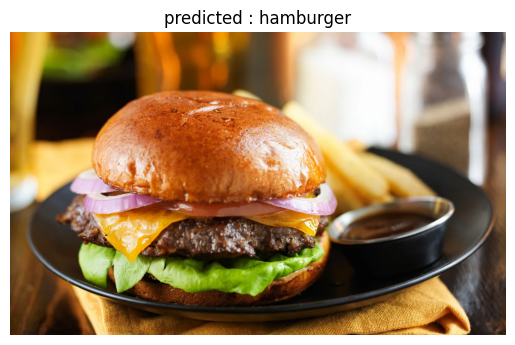

In [16]:
predict_for(path='test_image_2.webp')

1/1 [==============================] - 1s 655ms/step


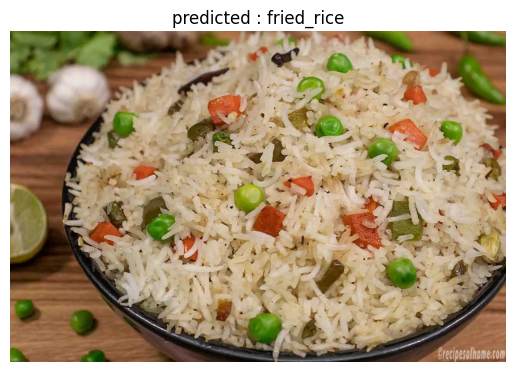

In [19]:
predict_for(path='test-image.webp')